In [1]:
import numpy as np
import tnn
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as f

from datasets import load_dataset 
from torch.utils.data import DataLoader

In [2]:
dataset = load_dataset("ylecun/mnist", num_proc=2)
train = dataset.get("train")
test = dataset.get("test")

In [3]:
def to_numpy(example):
    arr = np.reshape(example["image"], -1) / 255.0
    example["input"] = arr
    return example

train_dataset = train.map(to_numpy, num_proc=2).select_columns(["input", "label"])
test_dataset = test.map(to_numpy, num_proc=2).select_columns(["input", "label"])

In [4]:
def collate_fn(batch):
    inputs = torch.tensor([ex["input"] for ex in batch]).float()
    labels = torch.tensor([ex["label"] for ex in batch]).long()
    return inputs, labels

trainloader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False, collate_fn=collate_fn, num_workers=2)
testloader = data.DataLoader(test_dataset, batch_size=1024, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=2)

In [5]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(784, 512)
        self.drop_1 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(512, 512)
        self.drop_2 = nn.Dropout(0.25)
        self.linear_3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.drop_1(f.relu(self.linear_1(x)))
        x = self.drop_2(f.relu(self.linear_2(x)))
        return dict(logits=f.relu(self.linear_3(x)))

In [6]:
model = tnn.Model(MLP())
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), momentum=0.9)

In [7]:
trainer = tnn.Trainer(model, optim, loss_fn, trainloader, testloader, path="./train.h5", verbose=True)

In [8]:
metrics = trainer.train(epochs=25)

model using cuda
weights saved to ./train.h5/trajectory/weights-epoch-0
training started
(epoch: 1): (train loss: 2.2065, test loss: 1.9621, train acc: 0.3538, test acc: 0.5426)
weights saved to ./train.h5/trajectory/weights-epoch-1
(epoch: 2): (train loss: 1.4598, test loss: 0.8339, train acc: 0.6430, test acc: 0.8166)
weights saved to ./train.h5/trajectory/weights-epoch-2
(epoch: 3): (train loss: 0.7604, test loss: 0.5227, train acc: 0.7872, test acc: 0.8650)
weights saved to ./train.h5/trajectory/weights-epoch-3
(epoch: 4): (train loss: 0.5774, test loss: 0.4286, train acc: 0.8314, test acc: 0.8833)
weights saved to ./train.h5/trajectory/weights-epoch-4
(epoch: 5): (train loss: 0.5001, test loss: 0.3783, train acc: 0.8545, test acc: 0.8937)
weights saved to ./train.h5/trajectory/weights-epoch-5
(epoch: 6): (train loss: 0.4505, test loss: 0.3496, train acc: 0.8686, test acc: 0.9018)
weights saved to ./train.h5/trajectory/weights-epoch-6
(epoch: 7): (train loss: 0.4167, test loss: 0.3

In [9]:
model = tnn.Model(MLP())
landscape = tnn.Landscape.from_file("./train.h5", model, loss_fn, testloader, device="cuda", path="./train.h5", verbose=25)

In [10]:
data = landscape.create_meshgrid(resolution=25, endpoints=(-10.0, 10.0), mode="pca")

meshgrid creation using pca
model using cuda
meshgrid creation started
(iter: 25): iter loss: 5.9798
(iter: 50): iter loss: 5.9856
(iter: 75): iter loss: 5.9048
(iter: 100): iter loss: 5.7550
(iter: 125): iter loss: 5.5503
(iter: 150): iter loss: 5.3041
(iter: 175): iter loss: 5.0329
(iter: 200): iter loss: 4.7561
(iter: 225): iter loss: 4.4951
(iter: 250): iter loss: 4.2608
(iter: 275): iter loss: 4.0547
(iter: 300): iter loss: 3.8849
(iter: 325): iter loss: 3.7599
(iter: 350): iter loss: 3.6801
(iter: 375): iter loss: 3.6475
(iter: 400): iter loss: 3.6608
(iter: 425): iter loss: 3.7130
(iter: 450): iter loss: 3.8033
(iter: 475): iter loss: 3.9183
(iter: 500): iter loss: 4.0515
(iter: 525): iter loss: 4.2017
(iter: 550): iter loss: 4.3650
(iter: 575): iter loss: 4.5366
(iter: 600): iter loss: 4.7153
(iter: 625): iter loss: 4.8989
meshgrid creation complete
meshgrid saved to ./train.h5/landscape/meshgrid
optimizer path was saved to ./train.h5/landscape/optim_path
principle component va

In [11]:
path = "./train.h5"
metrics = tnn.get_metrics_from_file(path)

In [12]:
trajectory = tnn.get_trajectory_from_file(path)

In [13]:
landscape = tnn.get_landscape_from_file(path)

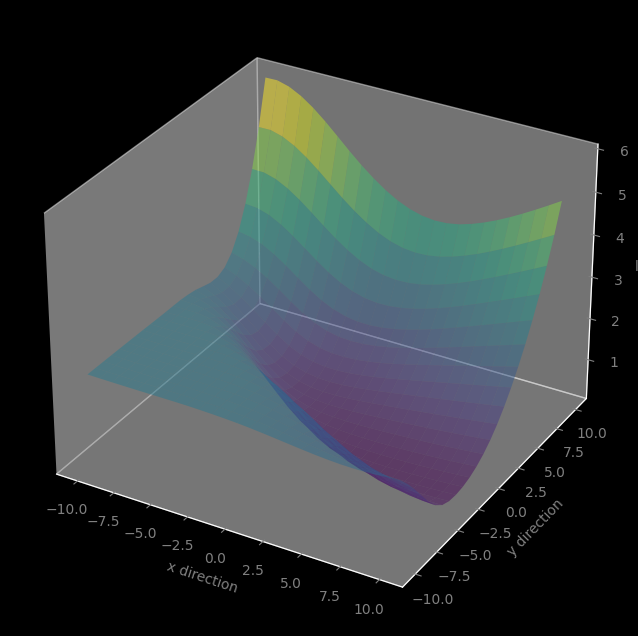

In [16]:
tnn.plot_surface_3D(landscape.get("meshgrid"), path="./3d-surface.png")

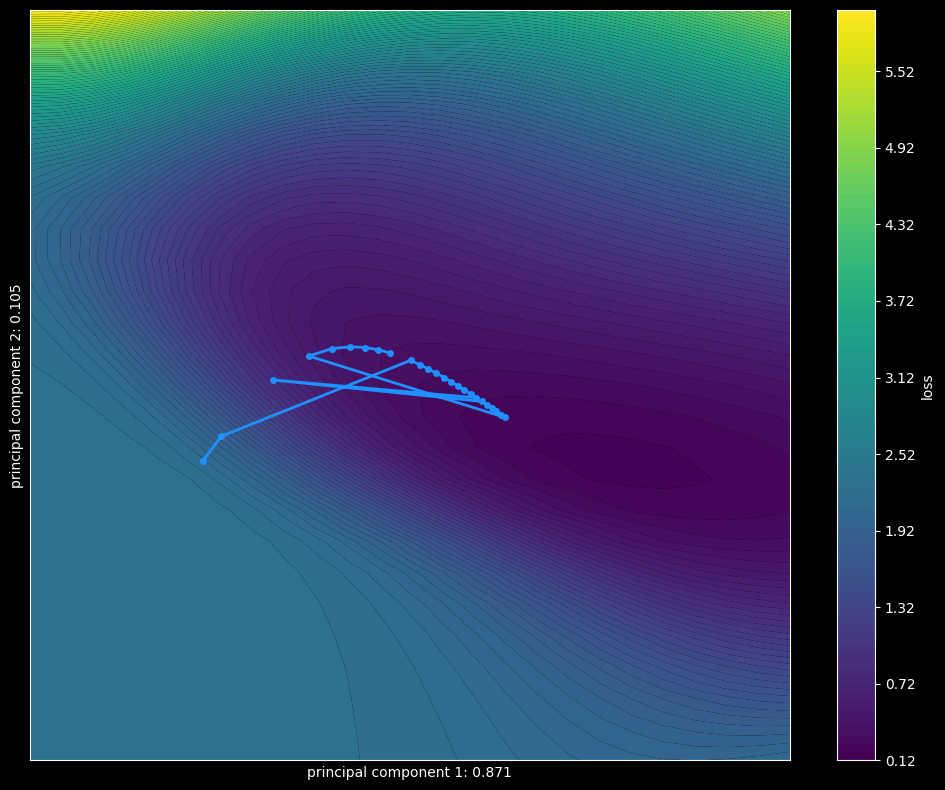

In [17]:
tnn.plot_contour(landscape.get("meshgrid"), variance=landscape.get("variance"), optim_path=landscape.get("optim_path"), path="./contour.png")

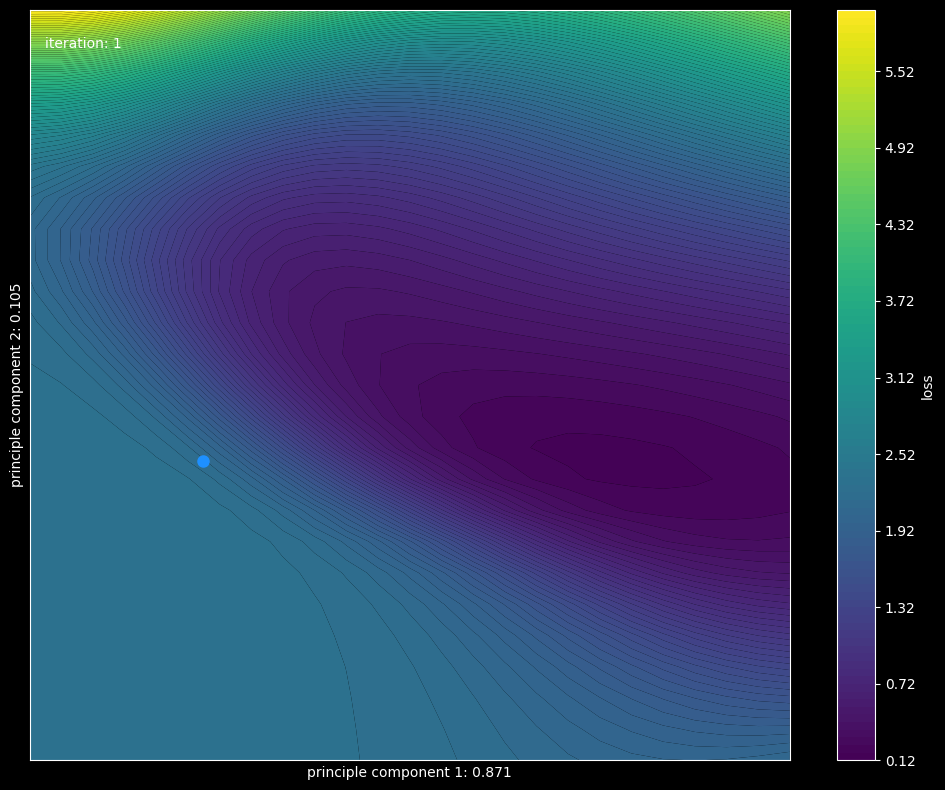

In [19]:
tnn.animate_contour(landscape.get("meshgrid"), landscape.get("optim_path"), landscape.get("variance"), path="./anim.gif")

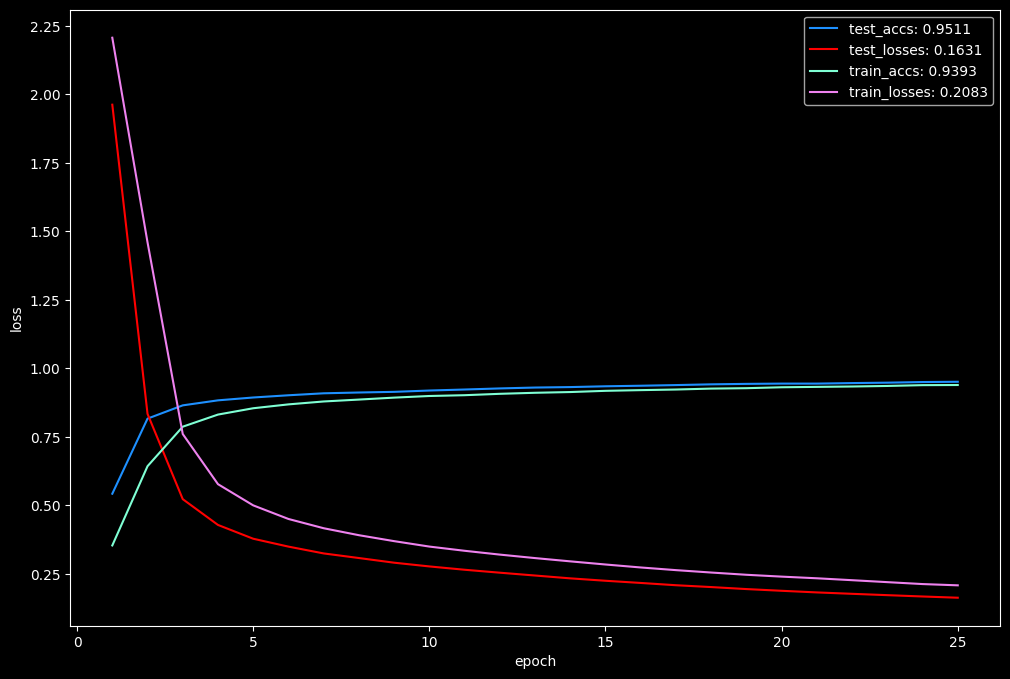

In [20]:
tnn.plot_metrics(metrics, path="./metrics.png")